# Package loading

In [8]:
# ...:: NEEDED PACKAGE ::...

import os
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
from tensorflow import keras

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.colors as mcolors
from skimage.transform import resize
import matplotlib.patches as patches

# Prerequisites before execution

In [9]:
# Just in case of unmounted Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# ...:: PARAMETERS : FILL THEN RUN ALL :::...
# ...:: PATH/NAME SECTION

# Define the directory path of the used model
modelDir = '/content/drive/My Drive/Colab Notebooks/FullStackProjectDeliverable/models/'
# Define the directory path of the used dataset
sourceImageDirectory = '/content/drive/My Drive/Colab Notebooks/FullStackProjectDeliverable/train_images_fullstack_test/'

# ...:: NAME SECTION : DO NOT TOUCH IS BETTER

# Define the model name used
modelName = 'unet_model_multilabels_256_meaniou.keras'
# Define the stripe model name used
modelStripeName = 'unet_model_stripe.keras'

# Model loading

In [11]:
# Dice Loss function used for model loading
def dice_loss(y_true, y_pred):
    # Convertir y_true en float32 pour correspondre à y_pred
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

custom_objects = {'dice_loss': dice_loss}

# Charger le modèle avec les custom_objects
unet_model = tf.keras.models.load_model(os.path.join(modelDir, modelName), custom_objects=custom_objects)
stripe_model = tf.keras.models.load_model(os.path.join(modelDir, modelStripeName))

# Unit prediction

In [12]:
# Local parameters

file = '0d675fc.jpg'

# Local parameters, DO NOT TOUCH

# Label list for class names
labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
# Color list for class
colors = [(51, 122, 183), (92, 184, 92), (240, 173, 78), (91, 192, 222)]
# colors = ['bleu', 'vert', 'orange','bleu plus clair']
# List of images labels for display
imageLabels = ['Image','Predicted mask','Overlay']

In [13]:
# ...:: FUNCTION SECTION ::...

def convert_image(init_image):
    ''' Load and convert image for model format : Grayscale and 256*256*1 '''

    init_image = cv2.cvtColor(init_image, cv2.IMREAD_GRAYSCALE)
    model_img = cv2.resize(init_image, (256, 256))
    model_img = np.expand_dims(model_img[:,:,0], axis=[0, -1])
    return model_img

def create_pred_image(pred, stripe, colors):
    # Empty array (256, 256, 3) for overlay
    pred_image = np.zeros((256, 256, 3), dtype=np.uint8)

    # for each pred mask
    for i in range(pred.shape[-1]):
        mask = tf.where(pred[0, :, :, i] > 0.75, 1, 0)
        # Get the matching color for mask value greater than .75
        pred_image[mask == 1] = colors[i]
    # Override value to black color for stripe predicted pixels
    stripe = tf.where(stripe[0, :, :, 0] > 0.5, 1, 0)
    pred_image[stripe == 1] = (0,0,0)

    return pred_image

def normalize_color(color):
    return tuple(c/255 for c in color)

def display_images_with_legend(images, colors, labels):
    fig, ax = plt.subplots(1, len(images))

    # display each image with title
    for i, img in enumerate(images):
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(imageLabels[i])

    # Legend subplot
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))

    # Créez un rectangle et un texte pour chaque couleur
    for i, (color, label) in enumerate(zip(colors, labels)):
        rect = patches.Rectangle((i*0.25, 0.5), 0.2, 0.4, facecolor=normalize_color(color))
        ax.add_patch(rect)
        ax.text(i*0.25+0.05, 0.7, label, fontsize=10)

    ax.axis('off')
    plt.show()

1/1 [==============================] - 1s 1s/step


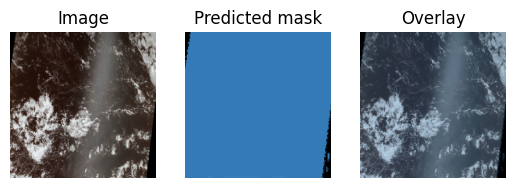

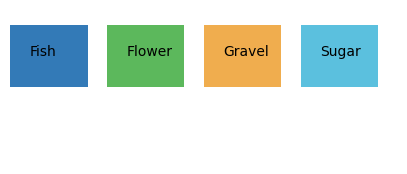

In [14]:
init_image_path = os.path.join(sourceImageDirectory, file)

init_image = cv2.imread(init_image_path)
init_image_shape = init_image.shape

model_image = convert_image(init_image)

overlay = cv2.resize(init_image, (256, 256), interpolation = cv2.INTER_AREA)
pred_mask = unet_model.predict(model_image)
pred_stripe = stripe_model.predict(model_image)

pred_image = create_pred_image(pred_mask, pred_stripe, colors)

overlay_image = cv2.addWeighted(overlay, .7, pred_image, .3, 0)

images = [overlay, pred_image, overlay_image]



# Affichez les images avec la légende
display_images_with_legend(images, colors, labels)